In [59]:
import numpy as np
from matplotlib.pyplot import *
from spectral import imshow, view_cube
import spectral.io.envi as envi 
from pysptools import spectro, noise 
from skimage import io
%matplotlib widget

In [48]:
find_index = lambda x, wvls: np.argmin(np.abs(wvls - x), axis = 0)

In [60]:
sample_image = io.imread(r'D:/Data/Data_HSI/CRAS-Dia2/Sample Images/santonio.jpeg')

In [2]:
fpath = r'D:/Data/Data_HSI/CRAS-Dia2/Refletancia/'
fname_wref = r'1 - Ref Branco/conversion_output/post_processing/ref_branco_dark_current_compensation_radiometric_correction'
fname_dref = r'2 - Ref Preto/conversion_output/post_processing/ref_preto_dark_current_compensation_radiometric_correction'
# fname_dref = r'3 - Vidro Verde/conversion_output/2024-02-28T12_53_51+0000_dark_frames'
fname_ref = r'3 - Santo Antonio/conversion_output/post_processing/santo_antonio_dark_current_compensation_radiometric_correction'

In [3]:
white_ref = envi.open(fpath + fname_wref + '.hdr', fpath + fname_wref + '.img')
dark_ref = envi.open(fpath + fname_dref + '.hdr', fpath + fname_dref + '.img')
data_ref = envi.open(fpath + fname_ref + '.hdr', fpath + fname_ref + '.img')

In [4]:
white_nparr = np.array(white_ref.load())
dark_nparr = np.array(dark_ref.load())
data_nparr = np.array(data_ref.load())

In [28]:
mask_W = white_nparr[100:1000, :, 150] > 0.045
ref_white = white_nparr[100:1000, :, :][mask_W].mean(axis = 0)
mask_D = dark_nparr[:, :, 150] < 0.001
ref_dark = dark_nparr[mask_D].mean(axis = 0)

In [52]:
corrected_nparr = ((data_nparr - ref_dark)/(ref_white - ref_dark))[50:950, 230:520, :]
data_reg = corrected_nparr
bands = np.array(data_ref.bands.centers)

In [64]:
specim_fps = 10
stage_speed = 1e-3
y_size = corrected_nparr.shape[0]/specim_fps*stage_speed * 1e2 #cm
x_size = 0.11* 1e2 #cm

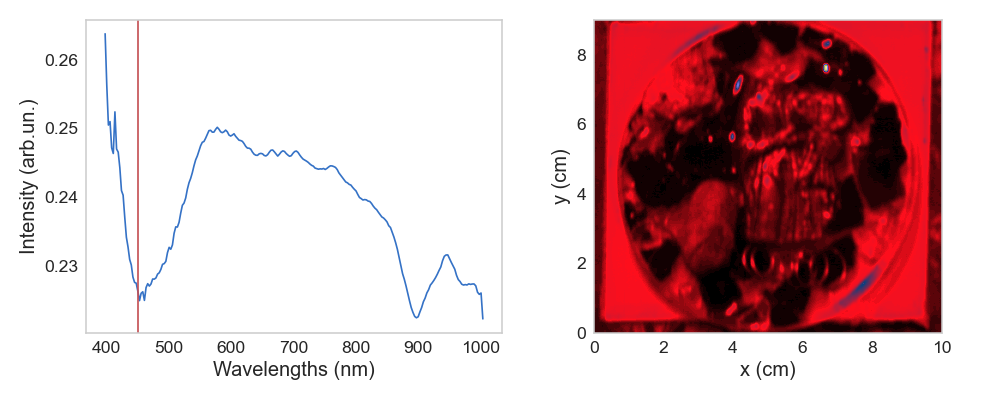

In [56]:
fig, ax = subplots(1, 2, figsize = (10, 4))

wl = 450 #450

axs = ax[0]
axs.plot(bands, data_reg.mean(axis = (0, 1)))
axs.axvline(wl, color = 'r')
axs.set_xlabel('Wavelengths (nm)')
axs.set_ylabel('Intensity (arb.un.)')
axs.grid(False)

axs = ax[1]
axs.imshow(data_reg[:, :, find_index(wl, bands)][::, ::-1], cmap = 'gist_stern', extent = (0, x_size, 0, y_size))
axs.grid(False)
axs.set_xlabel('x (cm)')
axs.set_ylabel('y (cm)')

fig.tight_layout()

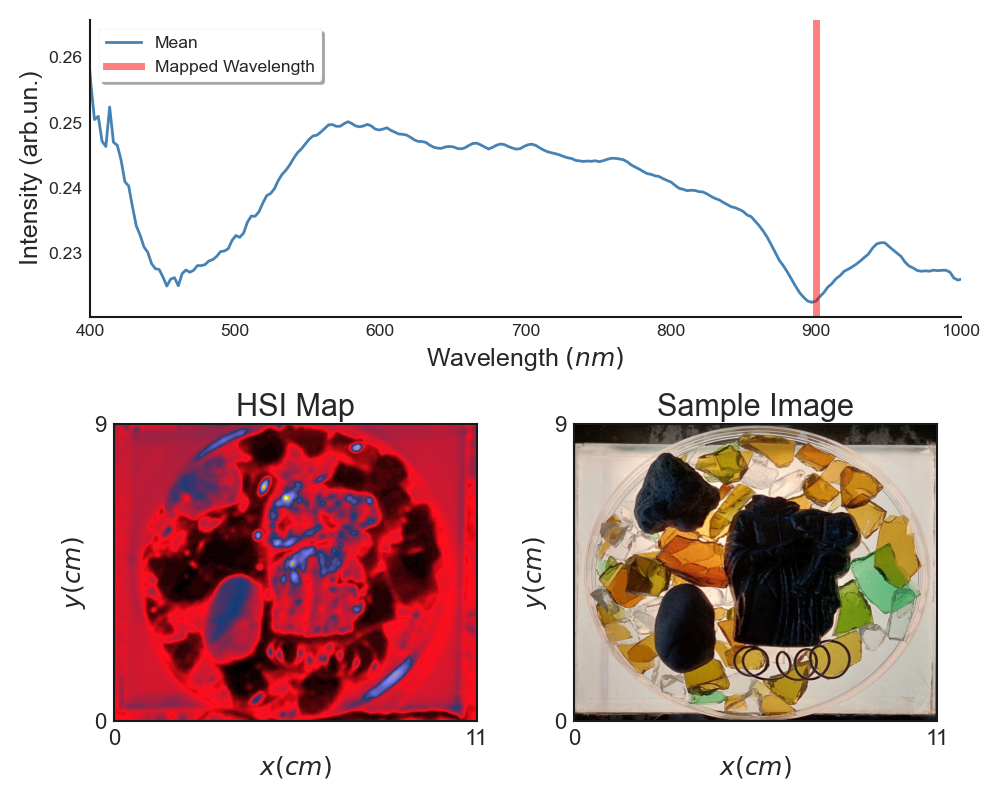

In [79]:
from matplotlib import gridspec

from mpl_toolkits.axes_grid1.inset_locator import mark_inset

matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['axes.edgecolor'] = '0.1'

fig = figure(tight_layout = True, figsize = (10, 8))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])


axs = ax1
# axs.set_title('Mean VIR-NIR HSI Transmittance Signal', fontsize = 22)
axs.plot(bands, data_reg.mean(axis = (0, 1)), lw = 2, ls = '-', color = 'steelblue', label = 'Mean')
axs.set_xlim(400, 1000)
axs.spines[['right', 'top']].set_visible(False)

wn = 900
wv = find_index(wn, bands)
line = axs.axvline(wn, lw = '5', alpha = 0.5, color = 'red', label = 'Mapped Wavelength')
axs.set_xlabel(r'Wavelength $(nm)$', fontsize = 18)
axs.set_ylabel(r'Intensity (arb.un.)', fontsize = 18)
axs.legend(fancybox = True, shadow = True)
axs.grid(False)

axs = ax2
axs.set_title('HSI Map', fontsize = 22)

axs.imshow(data_reg[:, :, find_index(wn, bands)][::, ::-1], cmap = 'gist_stern', extent = (0, x_size, 0, y_size))
axs.set_xlabel(r'$x(cm)$', fontsize = 18)
axs.set_ylabel(r'$y(cm)$', fontsize = 18)
axs.set_xticks([0, x_size])
axs.set_xticklabels([0, int(np.round(x_size))], fontsize = 16)
axs.set_yticks([0, y_size])
axs.set_yticklabels([0, int(np.round(y_size))], fontsize = 16)
axs.grid(False)

axs = ax3
axs.set_title('Sample Image', fontsize = 22)
axs.imshow(sample_image, extent = (0, x_size, 0, y_size))
axs.set_xlabel(r'$x(cm)$', fontsize = 18)
axs.set_ylabel(r'$y(cm)$', fontsize = 18)
axs.set_xticks([0, x_size])
axs.set_xticklabels([0, int(np.round(x_size))], fontsize = 16)
axs.set_yticks([0, y_size])
axs.set_yticklabels([0, int(np.round(y_size))], fontsize = 16)
axs.grid(False)

fig.tight_layout()
# savefig(f'Images/{wn}_reflectance.jpg', dpi = 300, bbox_inches = 'tight')

# RGB Image

In [69]:
boi = [650, 520, 450]
from skimage.filters import unsharp_mask

def make_rgb(bands_of_interest, sharpen = False):
    red, green, blue = bands_of_interest
    rgb_image = np.stack([data_reg[:, :, find_index(red, bands)], 
                          data_reg[:, :, find_index(green, bands)],
                          data_reg[:, :, find_index(blue, bands)]], axis = 2)
    if sharpen == True:
        return unsharp_mask(rgb_image, radius = 10, amount = 1)
    else:
        return rgb_image

img_boi = make_rgb(boi)

In [76]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

data_kmeans = img_boi.reshape(img_boi.shape[0]*img_boi.shape[1], -1)
scaled = MinMaxScaler().fit_transform(data_kmeans)

model = GaussianMixture(n_components = 4)
model.fit(scaled)
labels = model.predict(scaled).reshape(img_boi.shape[:2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


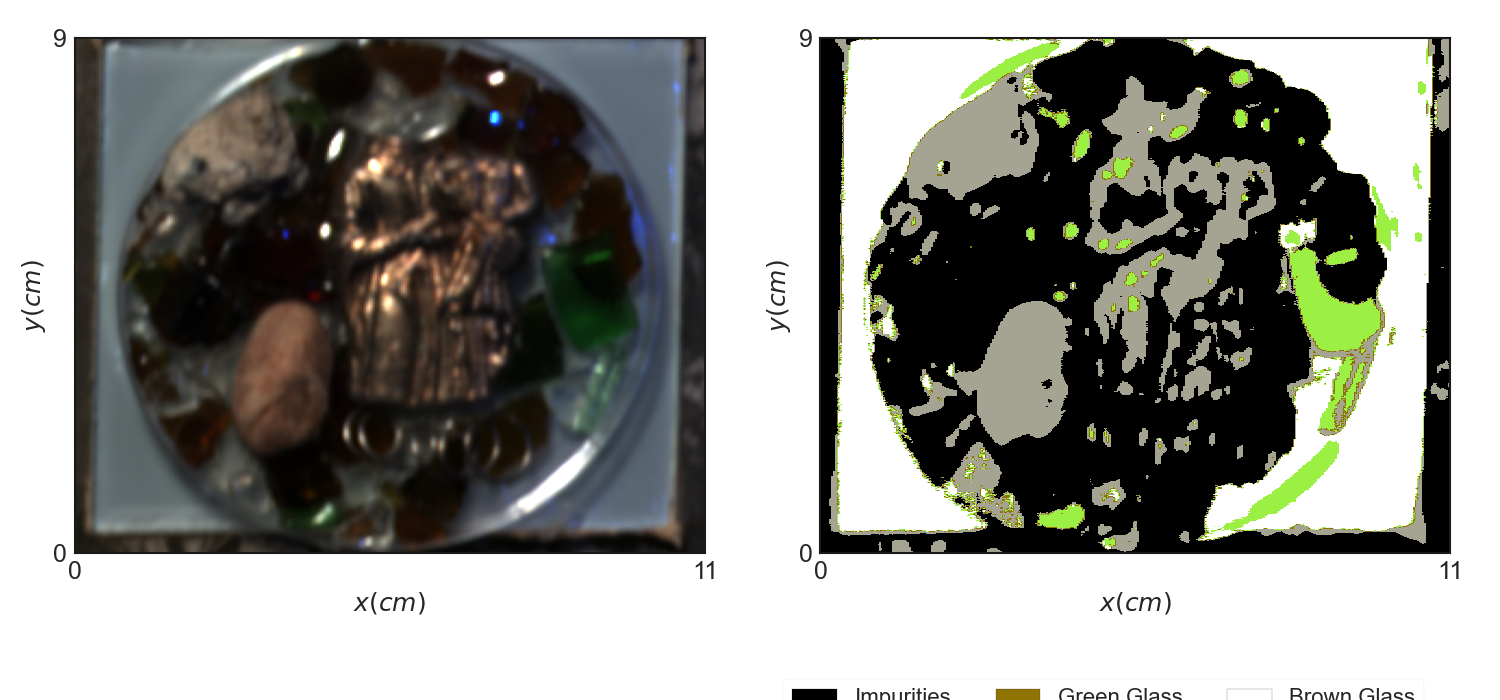

In [81]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
fig, ax = subplots(1, 2, figsize = (15, 7))

colors = ["xkcd:black", "xkcd:cement", "xkcd:poo", "xkcd:kiwi", "xkcd:white"]
name_list = ["Impurities", "Support", "Green Glass", "Acrylic", "Brown Glass"]
cmap = ListedColormap(colors)

hls = []
for color, cluster in zip(colors, name_list):
    patch = mpatches.Patch(color = color, label = cluster, ec = 'k')
    hls.append(patch)

# ax.set_title('Unsupervised Classification Results')

axs = ax[0]
axs.imshow(img_boi[::, ::-1], extent = (0, x_size, 0, y_size))
axs.set_xticks([0, x_size])
axs.set_xticklabels([0, int(np.round(x_size))], fontsize = 18)
axs.set_yticks([0, y_size])
axs.set_yticklabels([0, int(np.round(y_size))], fontsize = 18)
axs.set_xlabel(r'$x(cm)$', fontsize = 18)
axs.set_ylabel(r'$y(cm)$', fontsize = 18)
axs.grid(False)

axs = ax[1]
axs.imshow(labels[::, ::-1], extent = (0, x_size, 0, y_size), cmap = cmap)
axs.set_xticks([0, x_size])
axs.set_xticklabels([0, int(np.round(x_size))], fontsize = 18)
axs.set_yticks([0, y_size])
axs.set_yticklabels([0, int(np.round(y_size))], fontsize = 18)
axs.set_xlabel(r'$x(cm)$', fontsize = 18)
axs.set_ylabel(r'$y(cm)$', fontsize = 18)
axs.grid(False)
axs.legend(handles = hls,loc = 'lower center',  bbox_to_anchor = (0.45, -0.4), ncol = 3, fontsize = 16)

fig.tight_layout()

# savefig("Images/clustering.jpg", dpi = 300, bbox_inches = 'tight')